<a href="https://colab.research.google.com/github/nht0017/HIDS/blob/main/CICIDS_multiclassipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from glob import glob
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, auc, recall_score, precision_score,plot_confusion_matrix


## **Get Data from Kaggle**

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d cicdataset/cicids2017

! unzip cicids2017.zip

Saving kaggle.json to kaggle.json
 95% 218M/230M [00:02<00:00, 98.7MB/s]
100% 230M/230M [00:02<00:00, 85.1MB/s]
Archive:  cicids2017.zip
  inflating: MachineLearningCSV.md5  
  inflating: MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv  
  inflating: MachineLearningCSV/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv  


# **Data Process**

In [5]:
# Get a list of files from this dir
files_list = os.listdir('MachineLearningCSV/MachineLearningCVE/')

files_list.sort()

files_list

['Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
 'Friday-WorkingHours-Morning.pcap_ISCX.csv',
 'Monday-WorkingHours.pcap_ISCX.csv',
 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
 'Tuesday-WorkingHours.pcap_ISCX.csv',
 'Wednesday-workingHours.pcap_ISCX.csv']

## **Read in Data**

Enter INDEX number within files_list to read in that dataframe

In [6]:
INDEX =  6#@param {type:"integer"}

# Get df name
DATA = files_list[INDEX].split('.', 1)[0]
print('DATA:', DATA)
# Read in df
df = pd.read_csv('MachineLearningCSV/MachineLearningCVE/'+str(files_list[INDEX]), sep=',', header=0, engine='python')

df

DATA: Tuesday-WorkingHours


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,88,640,7,4,440,358,220,0,62.857143,107.349008,179,0,89.5,103.345698,1246875.000,17187.500000,64.000000,135.557286,445,1,640,106.666667,194.325157,497,1,538,179.333333,303.686242,530,4,0,0,0,0,164,104,10937.500000,6250.000000,0,220,66.500000,99.001837,9801.363636,0,0,0,1,0,0,0,0,0,72.545455,62.857143,89.5,164,0,0,0,0,0,0,7,440,4,358,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,88,900,9,4,600,2944,300,0,66.666667,132.287566,1472,0,736.0,849.859596,3937777.778,14444.444440,75.000000,192.795228,684,1,900,112.500000,252.411229,734,1,766,255.333333,435.323251,758,3,0,0,0,0,204,104,10000.000000,4444.444444,0,1472,253.142857,527.434262,278186.901100,0,0,0,1,0,0,0,0,0,272.615385,66.666667,736.0,204,0,0,0,0,0,0,9,600,4,2944,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1205,7,4,2776,2830,1388,0,396.571429,677.274651,1415,0,707.5,816.950631,4652282.158,9128.630705,120.500000,236.433336,777,1,1205,200.833333,397.058392,1008,1,927,309.000000,491.647231,876,1,0,0,0,0,164,104,5809.128631,3319.502075,0,1415,467.166667,690.098917,476236.515200,0,0,0,1,0,0,0,0,0,509.636364,396.571429,707.5,164,0,0,0,0,0,0,7,2776,4,2830,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,88,511,7,4,452,370,226,0,64.571429,110.276708,185,0,92.5,106.809800,1608610.568,21526.418790,51.100000,90.767652,299,1,511,85.166667,131.900594,349,1,462,154.000000,224.719826,412,1,0,0,0,0,164,104,13698.630140,7827.788650,0,226,68.500000,101.933579,10390.454550,0,0,0,1,0,0,0,0,0,74.727273,64.571429,92.5,164,0,0,0,0,0,0,7,452,4,370,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,773,9,4,612,2944,306,0,68.000000,134.933317,1472,0,736.0,849.859596,4600258.732,16817.593790,64.416667,148.698266,531,1,773,96.625000,196.665733,580,1,675,225.000000,348.901132,627,1,0,0,0,0,204,104,11642.949550,5174.644243,0,1472,254.000000,527.520762,278278.153800,0,0,0,1,0,0,0,0,0,273.538462,68.000000,736.0,204,0,0,0,0,0,0,9,612,4,2944,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445904,53,155,2,2,88,120,44,44,44.000000,0.000000,60,60,60.0,0.000000,1341935.484,25806.451610,51.666667,83.428612,148,3,3,3.000000,0.000000,3,3,4,4.000000,0.000000,4,4,0,0,0,0,64,64,12903.225810,12903.225810,44,60,50.400000,8.763561,76.800000,0,0,0,0,0,0,0,0,1,63.000000,44.000000,60.0,64,0,0,0,0,0,0,2,88,2,120,-1,-1,1,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
445905,59317,110,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0,0.000000,0

In [7]:
df.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,445909.000000,4.459090e+05,445909.000000,445909.000000,4.459090e+05,4.459090e+05,445909.000000,445909.000000,445909.000000,445909.000000,445909.000000,445909.000000,445909.000000,445909.000000,4.457080e+05,4.459090e+05,4.459090e+05,4.459090e+05,4.459090e+05,4.459090e+05,4.459090e+05,4.459090e+05,4.459090e+05,4.459090e+05,4.459090e+05,4.459090e+05,4.459090e+05,4.459090e+05,4.459090e+05,4.459090e+05,445909.000000,445909.0,445909.0,445909.0,4.459090e+05,4.459090e+05,4.459090e+05,4.459090e+05,445909.000000,445909.000000,445909.000000,445909.000000,4.459090e+05,445909.000000,445909.000000,445909.000000,445909.000000,445909.000000,445909.000000,445909.0,445909.000000,445909.00000,445909.000000,445909.000000,445909.000000,4.459090e+05,445909.0,445909.0,445909.0,445909.0,445909.0,445909.0,445909.000000,4.459090e+05,445909.000000,4.459090e+05,445909.000000,445909.000000,445909.000000,4.459090e+05,4.459090e+05,4.459090e+05,4.459090e+05,4.459090e+05,4.459090e+05,4.459090e+05,4.459090e+05,4.459090e+05
mean,8878.375745,1.077944e+07,11.800473,13.907212,5.302105e+02,2.186324e+04,173.346669,20.579979,48.528489,49.897094,426.185778,50.359952,170.371225,126.945652,inf,inf,8.969193e+05,1.457432e+06,3.983417e+06,1.617527e+05,1.049772e+07,1.894540e+06,1.038472e+06,3.880805e+06,1.218153e+06,9.818604e+06,1.792829e+06,8.081417e+05,3.348626e+06,1.202342e+06,0.060723,0.0,0.0,0.0,-1.502153e+05,-1.171400e+04,5.345103e+04,5.825596e+03,19.930762,465.214483,107.620046,135.258513,8.290961e+04,0.018380,0.060723,0.000336,0.242597,0.291687,0.115091,0.0,0.000339,0.68745,121.243156,48.528489,170.371225,-1.502153e+05,0.0,0.0,0.0,0.0,0.0,0.0,11.800473,5.302105e+02,13.907212,2.186163e+04,7408.452460,2792.060604,2.088341,-1.321786e+04,7.265964e+04,4.670517e+04,1.642092e+05,4.828426e+04,3.294459e+06,1.497105e+05,3.407025e+06,3.145407e+06
std,19522.889728,2.955629e+07,867.072428,1172.161547,5.676904e+03,2.625768e+06,472.450792,38.938350,113.195021,146.736325,881.676023,73.694913,311.356700,284.234647,NaN,NaN,4.250992e+06,5.771200e+06,1.342159e+07,2.852817e+06,2.942314e+07,9.512342e+06,3.817298e+06,1.340005e+07,9.269572e+06,2.861556e+07,9.459806e+06,3.505231e+06,1.273227e+07,9.205516e+06,0.238822,0.0,0.0,0.0,5.289797e+07,3.595580e+06,2.240127e+05,3.544440e+04,26.280681,946.383526,190.497397,254.194714,2.594933e+05,0.134323,0.238822,0.018338,0.428654,0.454540,0.319132,0.0,0.018399,0.53444,196.527086,113.195021,311.356700,5.289797e+07,0.0,0.0,0.0,0.0,0.0,0.0,867.072428,5.676904e+03,1172.161547,2.625473e+06,15609.495614,9744.606181,6.325197,2.666478e+06,6.205625e+05,3.601504e+05,1.049887e+06,5.649489e+05,1.258776e+07,1.982346e+06,1.293249e+07,1.240892e+07
min,0.000000,-4.000000e+00,1.000

**Check for columns with only constant**

If Label only has 1 value, then we don't analyze this df.


In [8]:
# Print a list of column containing only constant if exists
filt = np.std(df, axis=0) == 0

if filt.any == True:
  print(df.loc[:,filt])

Monday-WorkingHour only has normal class. Therefore, we do not run the algorithms on this dataset.


In [9]:
df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

## **Encoding Label**

In [10]:
# Look for classes have < 2 instances --> drop it

filt = df[' Label'].value_counts() < 2

if filt.any == True: # If there is any class has < 2 instances
  for i in range(len(filt)):
    if filt[i]:
      #print(i)
      drop_class = filt[filt == True].index[i] # Assuming only 1 class has 1 instance
      print('A class with only 1 instance is ',drop_class)
      print('df shape before dropping:', df.shape)

      # Filter only classes that have only 1 instance and then drop it.
      class_filt = df[' Label'] == drop_class
      df.drop(index = df[class_filt].index , inplace=True) 
      print('df shape after dropping:', df.shape)
else:
  print('No Class < 2 instances')

No Class < 2 instances


In [11]:
OG_labels = sorted( list(df[' Label'].unique() ))
print('Before encoding Label: ', OG_labels)
df[' Label'] = df[' Label'].astype("category").cat.codes

encoded_labels = sorted( list(df[' Label'].unique()))
print('After encoding Label: ', encoded_labels)

OG_y = df[' Label'] 
n_classes = len(OG_y.unique())

Before encoding Label:  ['BENIGN', 'FTP-Patator', 'SSH-Patator']
After encoding Label:  [0, 1, 2]


In [12]:
labels_dict = dict(zip(encoded_labels, OG_labels))
labels_dict

{0: 'BENIGN', 1: 'FTP-Patator', 2: 'SSH-Patator'}

**Check if the df has infinity value**
if Yes, replace it with NaN value so that we can drop it altogether in a bit


In [13]:
print('Has inf value?', np.any(np.isinf(df)))
if  np.any(np.isinf(df)):
  df.replace([np.inf, -np.inf], np.nan, inplace=True)

print('BEFORE removing NaN', df.shape)

# Removing NaN
df.dropna(axis=1, how='any', inplace=True)

print('AFTER removing NaN', df.shape)
print('Has NaN value?',np.any(np.isnan(df)))

Has inf value? True
BEFORE removing NaN (445909, 79)
AFTER removing NaN (445909, 77)
Has NaN value? False


## **Features Selection**

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2


r,c = df.shape
X = df.iloc[:,:c-1]
y = df[' Label']

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
best_features = featureScores.nlargest(30,'Score')
best_features  #print 30 best features

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [29 30 31 47 54 55 56 57 58 59] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,Specs,Score
28,Fwd PSH Flags,14520.435612
42,SYN Flag Count,14520.435612
46,URG Flag Count,4715.975417
36,Min Packet Length,4182.947774
11,Bwd Packet Length Min,3384.338595
66,act_data_pkt_fwd,2758.333856
44,PSH Flag Count,2657.319894
7,Fwd Packet Length Min,2009.324872
50,Average Packet Size,1741.752196
12,Bwd Packet Length Mean,1654.701550


In [15]:
# Enter SCORE as a lower limit to choose features
SCORE =  500#@param {type:"integer"}
best_column_indices = []

# Choose any features with scores above 1000
for index, row in best_features.iterrows():
  print(row[ "Score"])
  if row[ "Score"] > SCORE :
    best_column_indices.append(index)

X = X.iloc[:, best_column_indices]

X 

14520.435612157686
14520.435612157686
4715.975416778216
4182.947773912252
3384.338595284217
2758.3338560260427
2657.319893510788
2009.3248715510929
1741.7521956627809
1654.7015495909195
1654.7015495905168
1610.3514983276532
1479.062831123907
1472.5388725834703
1423.215896570171
1418.0858724769462
1062.268528912255
885.9896002931553
882.7338367019665
730.569857907823
717.0953085027204
607.6104144661822
517.425313599883
496.5786622369711
490.0720565024125
484.58215946213824
484.58215946213824
459.6371917601878
411.4325621505036
366.0551422148955


,Fwd PSH Flags,SYN Flag Count,URG Flag Count,Min Packet Length,Bwd Packet Length Min,act_data_pkt_fwd,PSH Flag Count,Fwd Packet Length Min,Average Packet Size,Bwd Packet Length Mean,Avg Bwd Segment Size,Init_Win_bytes_forward,Destination Port,ACK Flag Count,Packet Length Mean,Down/Up Ratio,Packet Length Std,Bwd Packet Length Max,Max Packet Length,Bwd Packet Length Std,Fwd Packet Length Max,Packet Length Variance,Init_Win_bytes_backward
0,0,0,0,0,0,2,1,0,72.545455,89.5,89.5,8192,88,0,66.500000,0,99.001837,179,220,103.345698,220,9801.363636,2053
1,0,0,0,0,0,2,1,0,272.615385,736.0,736.0,8192,88,0,253.142857,0,527.434262,1472,1472,849.859596,300,278186.901100,2053
2,0,0,0,0,0,2,1,0,509.636364,707.5,707.5,8192,88,0,467.166667,0,690.098917,1415,1415,816.950631,1388,476236.515200,2053
3,0,0,0,0,0,2,1,0,74.727273,92.5,92.5,8192,88,0,68.500000,0,101.933579,185,226,106.809800,226,10390.454550,2053
4,0,0,0,0,0,2,1,0,273.538462,736.0,736.0,8192,88,0,254.000000,0,527.520762,1472,1472,849.859596,306,278278.153800,2053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445904,0,0,0,44,60,1,0,44,63.000000,60.0,60.0,-1,53,0,50.400000,1,8.763561,60,60,0.000000,44,76.800000,-1
445905,0,0,1,0,0,0,0,0,0.000000,0.0,0.0,64,59317,1,0.000000,1,0.000000,0,0,0.000000,0,0.000000,256
445906,0,0,0,44,94,1,0,44,80.000000,94.0,94.0,-1,53,0,64.000000,1,27.386128,94,94,0.000000,44,750.000000,-1
445907,0,0,0,0,0,0,0,0,0.000000,0.0,0.0,122,54726,1,0.000000,1,0.000000,0,0,0.000000,0,0.000000,33304


In [16]:
X.describe()

,Fwd PSH Flags,SYN Flag Count,URG Flag Count,Min Packet Length,Bwd Packet Length Min,act_data_pkt_fwd,PSH Flag Count,Fwd Packet Length Min,Average Packet Size,Bwd Packet Length Mean,Avg Bwd Segment Size,Init_Win_bytes_forward,Destination Port,ACK Flag Count,Packet Length Mean,Down/Up Ratio,Packet Length Std,Bwd Packet Length Max,Max Packet Length,Bwd Packet Length Std,Fwd Packet Length Max,Packet Length Variance,Init_Win_bytes_backward
count,445909.000000,445909.000000,445909.000000,445909.000000,445909.000000,445909.000000,445909.000000,445909.000000,445909.000000,445909.000000,445909.000000,445909.000000,445909.000000,445909.000000,445909.000000,445909.00000,445909.000000,445909.000000,445909.000000,445909.000000,445909.000000,4.459090e+05,445909.000000
mean,0.060723,0.060723,0.115091,19.930762,50.359952,2.088341,0.242597,20.579979,121.243156,170.371225,170.371225,7408.452460,8878.375745,0.291687,107.620046,0.68745,135.258513,426.185778,465.214483,126.945652,173.346669,8.290961e+04,2792.060604
std,0.238822,0.238822,0.319132,26.280681,73.694913,6.325197,0.428654,38.938350,196.527086,311.356700,311.356700,15609.495614,19522.889728,0.454540,190.497397,0.53444,254.194714,881.676023,946.383526,284.234647,472.450792,2.594933e+05,9744.606181
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.750000,0.000000,0.000000,-1.000000,53.000000,0.000000,4.666667,0.00000,0.000000,0.000000,14.000000,0.000000,1.000000,0.000000e+00,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,74.000000,79.000000,79.000000,114.000000,80.000000,0.000000,58.600000,1.00000,26.838405,86.000000,90.000000,0.000000,41.000000,7.203000e+02,-1.000000
75%,0.000000,0.000000,0.000000,41.000000,96.000000,2.000000,0.000000,41.000000,119.862069,149.000000,149.000000,8192.000000,443.000000,1.000000,91.400000,1.00000,81.610661,179.000000,204.000000,0.000000,62.000000,6.660300e+03,247.000000
max,1.000000,1.000000,1.000000,1408.000000,2896.000000,1846.000000,1.000000,2065.000000,3893.333333,3735.736842,3735.736842,65535.000000,65505.000000,1.000000,3337.142857,35.00000,3811.855065,13140.000000,24820.000000,4113.240146,24820.000000,1.450000e+07,65535.000000


## **Data Cleaning**

In [17]:
label_range = np.arange(0, np.max(y.unique())+1)

label_range

array([0, 1, 2])

Class 0 - BENIGN: n=432074 (96.897%)
---------> Major class 0
Class 1 - FTP-Patator: n=7938 (1.780%)
Class 2 - SSH-Patator: n=5897 (1.322%)


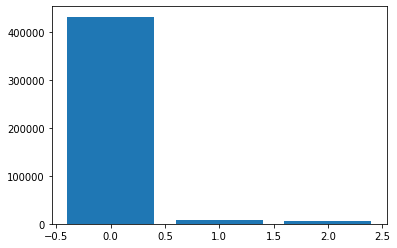

In [18]:
from collections import Counter

sub_X = pd.DataFrame()
MAX_CASES = 1

# summarize distribution
counter = Counter(df[' Label'])
for k,v in counter.items():
  per = v / len(df[' Label']) * 100
  print('Class %s - %s: n=%d (%.3f%%)' % (k, labels_dict[k], v, per))
  if v > MAX_CASES:
    MAX_CASES = v
    biggest_class = k
    print('---------> Major class %d'% k)

# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

Separating normal observations from intrusion ones. That way, if the dataset is imbalanced, we can easily bootstrap either class.

### **Removing duplicates from multiple classes**

- Separate each class into a df
- Remove duplicate rows that exist in multiple classes


In [19]:
# Rename column to integers
X.set_axis(np.arange(0, len(X.columns)), axis=1, inplace=True)

# Filter out normal class and different attacks and put them in separate dfs
data = []
for label in encoded_labels:
  filt = y == label
  data.append( X.loc[filt] )
  
# condense data from each class into different sets
class_set = {}
index = 0
for item in data:
  #print(item)
  class_list = item.values.tolist()
  class_set[index] = set(tuple(i) for i in class_list)
  index += 1

# print original sets lengths
print( 'Before cleaning:')
for key, value in class_set.items():
  print( 'Class %d len: %d' % (key, len(value)) )

Before cleaning:
Class 0 len: 180923
Class 1 len: 626
Class 2 len: 140


**When take the difference between multiple sets like (A - B - C), the result contain only A rows that doesn't exist in B nor C**

In [20]:
# Take the differences between 1 class and the others:
def difference_per_class ( class_number ):
  diff = class_set[class_number]
  for i in range(len(class_set)):
    # Normal class must be differentiated from all intrusion classes:
    #if class_number == NORMAL_CLASS_INDEX and i != class_number:
    #  diff -= class_set[i]
      #print('*************** NORMAL CLASS ALERT!!!!')
    #else:
      if i > class_number:
        diff -= class_set[i] 
  return diff

# Get the differences of all classes:
cleaned_class_set = {}
for key in class_set:
  cleaned_class_set[key] = difference_per_class(key)

print( 'After cleaning:')
MAX_CASES = 0
MAX_CLASS = 0
for key, value in cleaned_class_set.items():
  print( 'Class %d len: %d' % (key, len(value)) )
  if len(value) > MAX_CASES:
    MAX_CASES = len(value)
    MAX_CLASS = key

print('MAX CLASS %d has %d cases'% (MAX_CLASS, MAX_CASES))

After cleaning:
Class 0 len: 180922
Class 1 len: 626
Class 2 len: 140
MAX CLASS 0 has 180922 cases


In [21]:
# Append data from minor classes into 1 dataframe sub_X
sub_X = pd.DataFrame()
for key in cleaned_class_set:
  if key != MAX_CLASS:
    data_per_class = pd.DataFrame(cleaned_class_set[key])
    data_per_class['Labels'] = np.ones( len(cleaned_class_set[key]), dtype=int )*key  # The label value is the key value
    sub_X = sub_X.append(data_per_class, ignore_index=True)

# Append data from major class into major_X
major_X = pd.DataFrame(cleaned_class_set[MAX_CLASS])
major_X['Labels'] = MAX_CLASS
major_X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,Labels
0,0.0,0.0,0.0,41.0,73.0,5.0,0.0,41.0,67.700000,96.000000,96.000000,-1.0,53.0,0.0,61.545455,0.0,30.968899,119.0,119.0,26.558112,44.0,959.072727,-1.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,4693.0,10975.0,1.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,-1.0,0
2,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,35.318182,41.454545,41.454545,8192.0,80.0,0.0,33.782609,1.0,112.873604,456.0,456.0,137.489173,314.0,12740.450590,119.0,0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,913.0,4327.0,1.0,0.000000,1.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,256.0,0
4,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,259.315789,469.250000,469.250000,29200.0,443.0,0.0,246.350000,0.0,462.252184,1460.0,1460.0,628.772671,824.0,213677.081600,8201.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180917,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,335.500000,102.571429,102.571429,8192.0,443.0,0.0,309.692308,1.0,755.036355,535.0,2740.0,198.596624,2740.0,570079.897400,2053.0,0
180918,0.0,0.0,0.0,0.0,0.0,14.0,1.0,0.0,149.820513,204.842105,204.842105,8192.0,443.0,0.0,146.075000,0.0,371.312874,1400.0,1400.0,429.750737,1397.0,137873.250600,13970.0,0
180919,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,224.150000,402.111111,402.111111,8192.0,80.0,0.0,213.476190,0.0,497.106188,1810.0,1810.0,713.640393,430.0,247114.561900,980.0,0
180920,0.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,96.500000,91.470588,91.470588,8192.0,443.0,0.0,93.575758,1.0,163.141049,680.0,680.0,171.108196,517.0,26615.001890,368.0,0


# Bootstrap minor classes from sub_X to get the same amount of MAX_CASES from major class
print('sub_X before bootstrap:',sub_X.shape)
sub_X = sub_X.groupby('Labels').sample(n = MAX_CASES, replace=True)
print('After bootstrapping:', sub_X.shape)

In [22]:
sub_X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,Labels
0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,12.458333,12.533333,12.533333,29200.0,21.0,0.0,11.960000,1.0,12.866235,34.0,34.0,14.549750,29.0,165.540000,227.0,1
1,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,12.416667,12.533333,12.533333,29200.0,21.0,0.0,11.920000,1.0,12.880606,34.0,34.0,14.549750,29.0,165.910000,227.0,1
2,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,12.375000,12.533333,12.533333,29200.0,21.0,0.0,11.880000,1.0,12.868955,34.0,34.0,14.549750,29.0,165.610000,227.0,1
3,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,12.416667,12.533333,12.533333,29200.0,21.0,0.0,11.920000,1.0,12.848216,34.0,34.0,14.549750,29.0,165.076667,227.0,1
4,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,12.375000,12.533333,12.533333,29200.0,21.0,0.0,11.880000,1.0,12.846271,34.0,34.0,14.549750,29.0,165.026667,227.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,0.0,0.0,0.0,0.0,0.0,16.0,1.0,0.0,94.740000,88.548387,88.548387,29200.0,22.0,0.0,92.882353,1.0,193.912212,976.0,976.0,223.315000,640.0,37601.945880,247.0,2
762,0.0,0.0,0.0,0.0,0.0,16.0,1.0,0.0,86.418182,88.548387,88.548387,29200.0,22.0,0.0,84.875000,1.0,186.839655,976.0,976.0,223.315000,640.0,34909.056820,247.0,2
763,0.0,0.0,0.0,0.0,0.0,19.0,1.0,0.0,73.219178,76.707317,76.707317,29200.0,22.0,0.0,72.229730,1.0,164.759231,976.0,976.0,195.570223,640.0,27145.604040,247.0,2
764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,259.0,22.0,1.0,0.000000,1.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,247.0,2


In [23]:
# Append major_X into sub_X to create X w/o bootstrapping
X = sub_X.append(major_X)

# Reset index and then save Labels into y
X.reset_index(drop=True, inplace=True)
y = X['Labels']
X.drop(columns=['Labels'], inplace= True)

X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,12.458333,12.533333,12.533333,29200.0,21.0,0.0,11.960000,1.0,12.866235,34.0,34.0,14.549750,29.0,165.540000,227.0
1,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,12.416667,12.533333,12.533333,29200.0,21.0,0.0,11.920000,1.0,12.880606,34.0,34.0,14.549750,29.0,165.910000,227.0
2,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,12.375000,12.533333,12.533333,29200.0,21.0,0.0,11.880000,1.0,12.868955,34.0,34.0,14.549750,29.0,165.610000,227.0
3,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,12.416667,12.533333,12.533333,29200.0,21.0,0.0,11.920000,1.0,12.848216,34.0,34.0,14.549750,29.0,165.076667,227.0
4,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,12.375000,12.533333,12.533333,29200.0,21.0,0.0,11.880000,1.0,12.846271,34.0,34.0,14.549750,29.0,165.026667,227.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181683,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,335.500000,102.571429,102.571429,8192.0,443.0,0.0,309.692308,1.0,755.036355,535.0,2740.0,198.596624,2740.0,570079.897400,2053.0
181684,0.0,0.0,0.0,0.0,0.0,14.0,1.0,0.0,149.820513,204.842105,204.842105,8192.0,443.0,0.0,146.075000,0.0,371.312874,1400.0,1400.0,429.750737,1397.0,137873.250600,13970.0
181685,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,224.150000,402.111111,402.111111,8192.0,80.0,0.0,213.476190,0.0,497.106188,1810.0,1810.0,713.640393,430.0,247114.561900,980.0
181686,0.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,96.500000,91.470588,91.470588,8192.0,443.0,0.0,93.575758,1.0,163.141049,680.0,680.0,171.108196,517.0,26615.001890,368.0


# Number of cases to split into train and test sets
CASES = 5000
CASES_PER_CLASS = int(CASES/n_classes)
X = sub_X.append(major_X, ignore_index=False)
print('After appending all classes: X shape:', X.shape)


# Sample each class with the same number of cases
if CASES_PER_CLASS > len(major_X):
  replacement = True
else:
  replacement = False
X = X.groupby('Labels').apply(lambda x: x.sample(CASES_PER_CLASS, replace = replacement))
#X.drop(columns=['Labels'], inplace= True)

#X = X.droplevel('Labels')


In [24]:
y

0         1
1         1
2         1
3         1
4         1
         ..
181683    0
181684    0
181685    0
181686    0
181687    0
Name: Labels, Length: 181688, dtype: int64

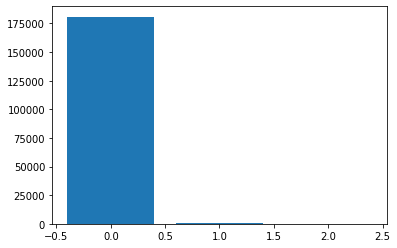

0    180922
1       626
2       140
Name: Labels, dtype: int64

In [25]:
# summarize distribution
def print_dist(data):
  counter = Counter(data)
  # plot the distribution
  plt.bar(counter.keys(), counter.values())
  plt.show()

print_dist(y)
y.value_counts()

# **Data Partition**

In [26]:
# Spliting into training and testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y) 

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((127181, 23), (127181,), (54507, 23), (54507,))

## **Oversample data**
 **Upsampling minor classes in training set to ensure the algs can learn from a balanced data**

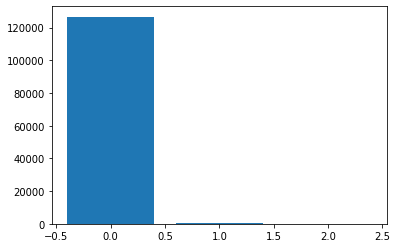

Max Class 0 has 126645 cases
Second Max Class len 438


Before upsampling minor classes: (536, 24)
After upsampling: (253290, 24) 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


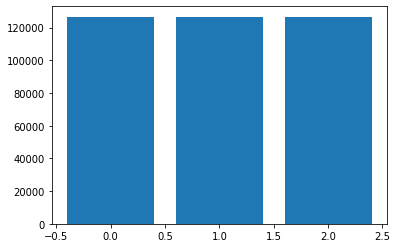

In [27]:
def over_sample(data, label):
  print_dist(label)

  ## Make sure y_train is balanced by upsampling minor classes up to the second biggest class

  # Look for the second biggest class
  label_dist = label.value_counts()
  max = 0; max_class = 0; max_2, max_2_class = 0, 0
  for i in range(len(label_dist)):
    if label_dist[i] > max:
      max_2 = max
      max_2_class = max_class
      max = label_dist[i]
      max_class = i
    elif max_2 < label_dist[i] < max:
      max_2 = label_dist[i]
      max_2_class = i

  print('Max Class %d has %d cases\nSecond Max Class len %d' % (max_class, max, max_2) )

  # Upsample minor classes upto the second biggest class
  filt = label == max_class
  #filt2 = label == max_2_class
  #major_y_train = label.loc[filt].append(label.loc[filt2])
  major_y_train = label.loc[filt]
  major_train = data.loc[data.index.isin(major_y_train.index)]

  # get the complement of the major classes indices
  minor_train = data.loc[~data.index.isin(major_y_train.index)]
  # get minor labels
  minor_train['Labels'] = label.loc[label.index.isin(minor_train.index)]
  #df[~df.index.isin(df_a.index+df_b.index)]
  print('\n\nBefore upsampling minor classes:', minor_train.shape)

  minor_train = minor_train.groupby('Labels').sample(n = max, replace=True) 
  minor_y_train = minor_train['Labels']
  print('After upsampling:', minor_train.shape, '\n')

  data = major_train.append(minor_train.drop(columns='Labels'), ignore_index = True)
  label = major_y_train.append(minor_y_train, ignore_index=True )
  label.astype('int32')
  print_dist(label)

  return data, label

x_train, y_train = over_sample(x_train, y_train)
#x_test,  y_test  = over_sample(x_test, y_test)

In [28]:
# Binarize y_train and y_test
from sklearn.preprocessing import label_binarize

# Binarize the output
if n_classes > 2:
  encoded_y_train = pd.DataFrame(label_binarize(y_train, classes = label_range))
  encoded_y_test  = pd.DataFrame(label_binarize(y_test, classes = label_range))
else:
  encoded_y_train = y_train
  encoded_y_test  = y_test

print('n_classes:', n_classes)

x_train.shape, encoded_y_train.shape, x_test.shape, encoded_y_test.shape

n_classes: 3


((379935, 23), (379935, 3), (54507, 23), (54507, 3))

In [29]:
encoded_y_train

,0,1,2
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
379930,0,0,1
379931,0,0,1
379932,0,0,1
379933,0,0,1


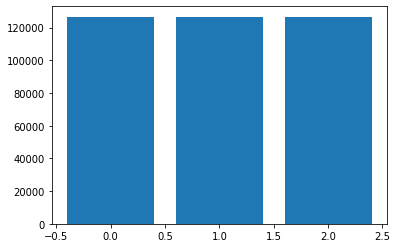

379935

In [30]:
# plot the distribution
counter = Counter(y_train)

plt.bar(counter.keys(), counter.values())
plt.show()
len(y_train)

In [31]:
print('TRAIN',y_train.value_counts())
class_w =  y_test.value_counts()
print('TEST', class_w)

TRAIN 2    126645
1    126645
0    126645
Name: Labels, dtype: int64
TEST 0    54277
1      188
2       42
Name: Labels, dtype: int64


In [32]:
class_w.to_list()

[54277, 188, 42]


# **Performance Measures**


1.   Function calc_false_positive: Calculates FPR
2.   Function print_performance: Formats printing performance metrics and ROC curve for each model
3.   Function color_confusion_matrix: prints out a heatmap of confusion matrix in blue color scale
4.   Graphing overlaid ROC curves, where each one represents a model AUC score





In [33]:
from itertools import cycle

# Plot all ROC curves
def plot_ROC (performance_measures, labels_dict, model_name):
  plt.figure(figsize=(10,6))
  fpr = performance_measures.get('fpr')
  tpr = performance_measures.get('tpr')
  roc_auc = performance_measures.get('auc')
  colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink', 'green'])

  if n_classes > 2:
    plt.plot( fpr["micro"] , tpr["micro"], 
            label='micro-average (AUC = {0:0.4f})'.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average (AUC = {0:0.4f})'.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='{0} (AUC = {1:0.4f})'
                ''.format(labels_dict[i], roc_auc[i]))
  else:
    plt.plot(fpr, tpr, lw=2,
                label='AUC = {0:0.4f}'.format(roc_auc))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC of multi-class using '+ model_name)
  plt.legend(loc="lower right",fancybox=True, shadow=True, ncol=2, fontsize = 10)
  plt.show()

def get_cmatrix(model_name ,true_labels, pred_labels):
  if n_classes <= 2:
    return confusion_matrix(true_labels, pred_labels)
  else:
    return confusion_matrix(true_labels.values.argmax(axis=1), pred_labels.argmax(axis=1))
  

# This function prints performance metrics and ROC curve given the model name, true labels and predicted labels
def print_performance( model_name, true_labels, pred_labels, label_names):
  # rows are actual, columns are predicted
  #cmatrix = confusion_matrix(true_labels.values.argmax(axis=1), pred_labels.argmax(axis=1))
  cmatrix = get_cmatrix(model_name, true_labels, pred_labels)

  print('Confusion Matrix: \n',cmatrix)
  print('\nClassification report:', classification_report(true_labels, pred_labels, target_names = label_names, zero_division=0), sep='\n')
  print('\nTesting Accuracy: %.2f'% accuracy_score(true_labels, pred_labels))
  print('Micro AUC: %.4f'% roc_auc_score(true_labels, pred_labels, average='micro', multi_class='ovr'))
  print('Macro AUC: %.4f'% roc_auc_score(true_labels, pred_labels, average='macro', multi_class='ovr'))

# Plot a heatmap of confusion matrix given the model name, a classifier model, testing data and the predicted label
def color_confusion_matrix(model_name, true_labels, pred_labels, labels):
  plt.figure(figsize=(10,10))
  #cmatrix = confusion_matrix(true_labels.values.argmax(axis=1), pred_labels.argmax(axis=1))
  cmatrix = get_cmatrix(model_name, true_labels, pred_labels)
  rows, cols = cmatrix.shape

  plt.figure(figsize=(8,8))
  plt.imshow(cmatrix, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix of '+ model_name)
  plt.colorbar()
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=90)
  plt.yticks(tick_marks, labels)
  plt.xlabel('Predicted Labels')
  plt.ylabel('Actual Labels')
 
  large_vals = cmatrix.max()/2  #comment out because there are too many classes --> no need number
  for i in range(rows):
    for j in range(cols):
      if cmatrix[i, j] >= large_vals:
        color='white'
      else:
        color = 'black'
      plt.text(j, i, cmatrix[i, j], horizontalalignment = 'center', color= color)
  

## Record fpr, tpr and roc_auc info of each model on each class
def record_measures(true_labels, pred_labels):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  if n_classes > 2:
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels.iloc[:, i], pred_labels[:, i])  
        roc_auc[i] = auc(fpr[i], tpr[i])

        #if np.isnan( roc_auc[i] ):
        #  roc_auc[i] = 0.5
        print('ROC AUC Class ',i,':', roc_auc[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve( true_labels.to_numpy().reshape(-1), pred_labels.reshape(-1))
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-avg ROC curve and area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    measures = {}
    measures['fpr'], measures['tpr'] = fpr, tpr
    measures['auc'] = roc_auc
    
  else:
    measures = {}
    measures['fpr'], measures['tpr'], thresh = roc_curve(true_labels, pred_labels)
    measures['auc'] = roc_auc_score(y_train, y_pred)

  return measures
  

# Calculate either avg fpr or tpr given A DICT performance measurements of a model
# key_str can be: fpr, tpr, auc  ==== DEL
def get_ROC_info(info, key_str):
  fpr = info.get(key_str)
  fpr_arr = []
  for key in fpr:
    if key_str == 'auc':
      fpr_arr.append(fpr[key])
    elif key != 'micro' and key != 'macro':
      if len(fpr[key]) == 2: # incase some fpr only has [0, 1]
        #print('has < 2 elements', fpr[key], type(fpr[key]))
        fpr[key] = np.insert( fpr[key], 1, 0)
      fpr_arr.append(fpr[key])
    

  # Stack the fpr of each class on top of each other
  #print('get ROC info', key_str)
  #print(fpr_arr)
  fpr_arr = pd.DataFrame(np.row_stack(fpr_arr))

  # Get avg fpr
  return fpr_arr.mean().tolist()

# Save avg fpr, tpr and auc of a model to a dict ===== DEL
def combine_ROC_info(info):
  model_dict = {}
  model_dict['tpr'] = get_ROC_info(info, 'tpr')
  model_dict['fpr'] = get_ROC_info(info, 'fpr')
  model_dict['auc'] = get_ROC_info(info, 'auc')
  return model_dict


# Graphing overlaid ROC curves, where each one represents a model AUC score
def graph_multi_ROC (roc_type = 'micro'):
  # Set color for each model
  colors = {'DT': 'magenta','RF': 'green','KNN': 'darkturquoise', 'BERT': 'deeppink', 
            'GPT': 'deeppink', 'LGBM': 'lightcoral', 'XGB': 'blue'}
  # Set marker for each model          
  markers = { 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'BERT':'<--', 'GPT': '>--',
             'LGBM': '1--', 'XGB': '2--'}
  
  plt.figure(figsize=(9,6))
## need to get the average fpr and tpr of all class
  if n_classes > 2:
    DT_fpr = DT_test.get('fpr')[roc_type];    DT_tpr = DT_test.get('tpr')[roc_type]; DT_auc = DT_test.get('auc')[roc_type]
    #print(DT, DT_auc)
    RF_fpr = RF_test.get('fpr')[roc_type];    RF_tpr = RF_test.get('tpr')[roc_type];    RF_auc  = RF_test.get('auc')[roc_type]
    KNN_fpr = KNN_test.get('fpr')[roc_type];  KNN_tpr = KNN_test.get('tpr')[roc_type];  KNN_auc = KNN_test.get('auc')[roc_type]
    LGBM_fpr = LGBM_test.get('fpr')[roc_type];LGBM_tpr = LGBM_test.get('tpr')[roc_type];LGBM_auc= LGBM_test.get('auc')[roc_type]
    XGB_fpr = XGB_test.get('fpr')[roc_type];  XGB_tpr = XGB_test.get('tpr')[roc_type];  XGB_auc = XGB_test.get('auc')[roc_type]
    BERT_fpr = BERT_test.get('fpr')[roc_type];BERT_tpr = BERT_test.get('tpr')[roc_type];BERT_auc= BERT_test.get('auc')[roc_type]
  else:
    DT = DT_test; DT_auc = DT.get('auc')
    RF = RF_test; RF_auc = RF.get('auc')
    KNN = KNN_test; KNN_auc = KNN.get('auc')
    LGBM = LGBM_test; LGBM_auc = LGBM.get('auc')
    XGB = XGB_test; XGB_auc = XGB.get('auc')
    BERT = BERT_test; BERT_auc = BERT.get('auc')

  plt.plot(DT_fpr, DT_tpr,   markers.get('DT'),  color=colors.get('DT'),  label="DT - AUC=" + str( round(DT_auc, 4) )) 
  plt.plot(RF_fpr,  RF_tpr,  markers.get('RF'),  color=colors.get('RF'),  label="RF - AUC=" + str( round(RF_auc, 4) ))
  plt.plot(KNN_fpr, KNN_tpr, markers.get('KNN'), color=colors.get('KNN'), label="KNN - AUC="+ str( round(KNN_auc, 4) ))
  plt.plot(LGBM_fpr,LGBM_tpr,markers.get('LGBM'),color=colors.get('LGBM'),label="LGBM - AUC=" +str( round(LGBM_auc, 4) ))
  plt.plot(XGB_fpr, XGB_tpr, markers.get('XGB'), color=colors.get('XGB'), label="XGB - AUC="+ str( round(XGB_auc,4) ))

  plt.plot(BERT_fpr, BERT_tpr, markers.get('BERT'), color=colors.get('BERT'),label="BERT - AUC="+ str( round(BERT_auc,4) ))
  #plt.plot(GPT_test.get('fpr'),GPT_test.get('tpr'), markers.get('GPT'), color=colors.get('GPT'),  label="GPT-2 - AUC="+ str(GPT_test.get('auc').round(3)))

  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right',fontsize= 10) 
  plt.title( 'Testing '+ roc_type+' ROCs on ' + DATA)
  plt.show()

# **Decision Tree**

ROC AUC Class  0 : 0.9999052469501362
ROC AUC Class  1 : 0.9999861818468948
ROC AUC Class  2 : 0.9999664416281732

TESTING
Confusion Matrix: 
 [[54266     4     7]
 [    0   188     0]
 [    0     1    41]]

Classification report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     54277
 FTP-Patator       0.97      1.00      0.99       188
 SSH-Patator       0.85      0.98      0.91        42

   micro avg       1.00      1.00      1.00     54507
   macro avg       0.94      0.99      0.97     54507
weighted avg       1.00      1.00      1.00     54507
 samples avg       1.00      1.00      1.00     54507


Testing Accuracy: 1.00
Micro AUC: 0.9998
Macro AUC: 0.9960
ROC AUC Class  0 : 0.9998986679440647
ROC AUC Class  1 : 0.9999539755886523
ROC AUC Class  2 : 0.9880309766429294


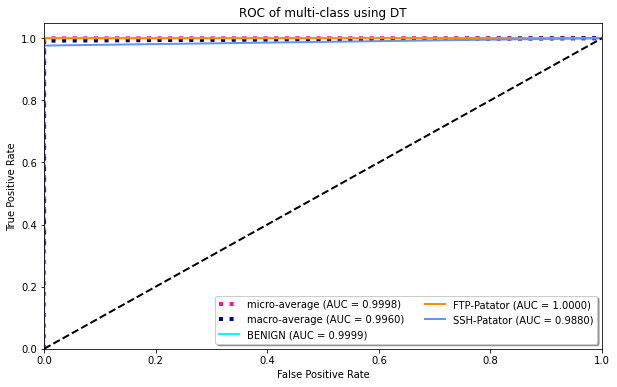

Train AUC: 1.0000 vs Test AUC: 0.9998


In [34]:
from sklearn.tree import DecisionTreeClassifier

# Create and Train DecTree model
decTree = DecisionTreeClassifier(criterion='gini', min_samples_split=10,min_samples_leaf=5,max_features='auto')
decTree = decTree.fit(x_train, encoded_y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = decTree.predict(x_train)
DT_train = record_measures(encoded_y_train, y_pred)


# Predict testing data
y_predicted = decTree.predict(x_test)

# Print performance measures
print('\nTESTING')
print_performance('Decision Tree', encoded_y_test, y_predicted, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
DT_test = record_measures(encoded_y_test, y_predicted)

# Print ROC Curve
plot_ROC(DT_test, labels_dict, 'DT')
if n_classes > 2:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(DT_train['auc']['micro'], DT_test['auc']['micro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(DT_train['auc'], DT_test['auc']))



<Figure size 720x720 with 0 Axes>

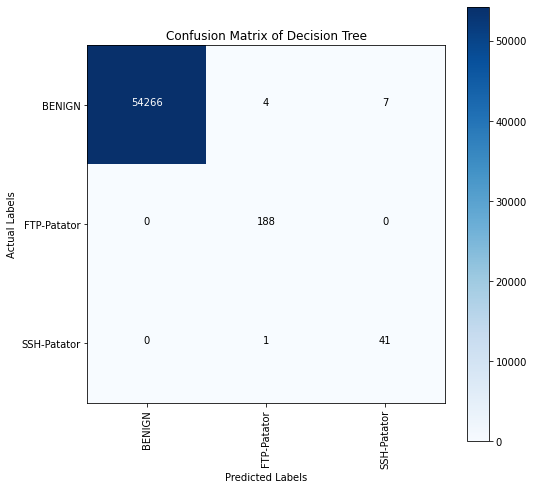

In [35]:
# Color Confusion Matrix
color_confusion_matrix('Decision Tree', encoded_y_test, y_predicted, OG_labels)

# **Random Forest**

ROC AUC Class  0 : 0.9998973508626476
ROC AUC Class  1 : 0.9999822338031505
ROC AUC Class  2 : 0.9999802597812784

TESTING
Confusion Matrix: 
 [[54264     8     5]
 [    1   187     0]
 [    0     0    42]]

Classification report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     54277
 FTP-Patator       0.96      0.99      0.98       188
 SSH-Patator       0.89      1.00      0.94        42

   micro avg       1.00      1.00      1.00     54507
   macro avg       0.95      1.00      0.97     54507
weighted avg       1.00      1.00      1.00     54507
 samples avg       1.00      1.00      1.00     54507


Testing Accuracy: 1.00
Micro AUC: 0.9998
Macro AUC: 0.9990
ROC AUC Class  0 : 0.9998341839084695
ROC AUC Class  1 : 0.9972667864737585
ROC AUC Class  2 : 0.9999540989626365


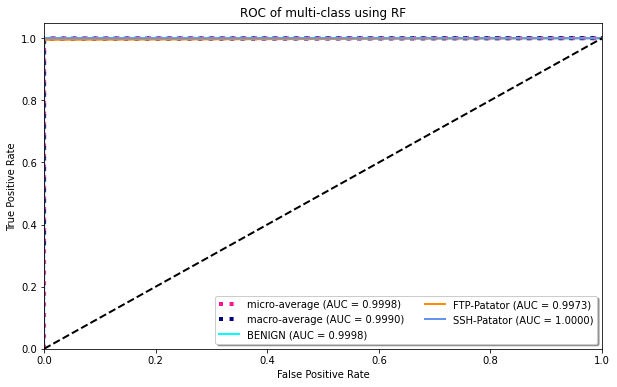

Train AUC: 1.0000 vs Test AUC: 0.9998


In [36]:
from sklearn.ensemble import RandomForestClassifier

# Build model
randomForest = RandomForestClassifier(max_depth=None, min_samples_split=10, min_samples_leaf=5, 
                                      max_features='auto', bootstrap=True,verbose=0, criterion='gini')
# Train the model with training set
randomForest.fit(x_train, encoded_y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = randomForest.predict(x_train)
RF_train = record_measures(encoded_y_train, y_pred)

# Predict the labels for testing set
y_predicted = randomForest.predict(x_test)

# Print performance measures
print('\nTESTING')
print_performance('Random Forest', encoded_y_test, y_predicted, OG_labels)

# Recording TPR and FPR for the multi-ROC curves
RF_test = record_measures(encoded_y_test, y_predicted)

# Print ROC Curve
plot_ROC(RF_test, labels_dict, 'RF')
if n_classes > 2:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(DT_train['auc']['micro'], DT_test['auc']['micro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(DT_train['auc'], DT_test['auc']))


<Figure size 720x720 with 0 Axes>

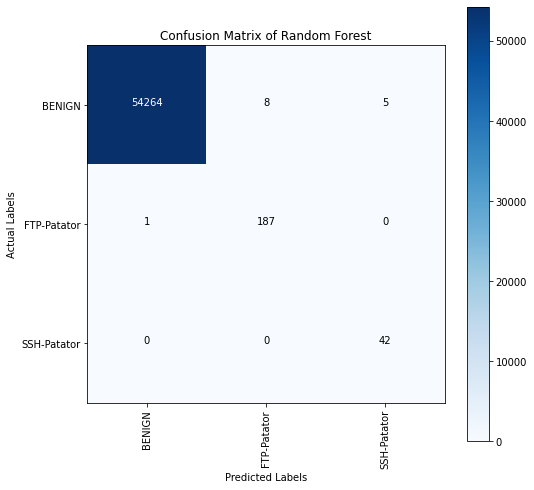

In [37]:
# Color Confusion Matrix
color_confusion_matrix('Random Forest', encoded_y_test, y_predicted, OG_labels)

# **KNN**

Since KNN takes longer to classify this amount of data, we randomly sample 10K normal rows and 10K intrusion rows to train and test KNN.

ROC AUC Class  0 : 0.999877610643926
ROC AUC Class  1 : 0.9999960519562557
ROC AUC Class  2 : 0.9999427533657074
Confusion Matrix: 
 [[54245     8    24]
 [    2   186     0]
 [    5     2    35]]

Classification report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     54277
 FTP-Patator       0.95      0.99      0.97       188
 SSH-Patator       0.59      0.83      0.69        42

   micro avg       1.00      1.00      1.00     54507
   macro avg       0.85      0.94      0.89     54507
weighted avg       1.00      1.00      1.00     54507
 samples avg       1.00      1.00      1.00     54507


Testing Accuracy: 1.00
Micro AUC: 0.9994
Macro AUC: 0.9652
ROC AUC Class  0 : 0.9844878245329313
ROC AUC Class  1 : 0.9945888022411343
ROC AUC Class  2 : 0.9164463416873221


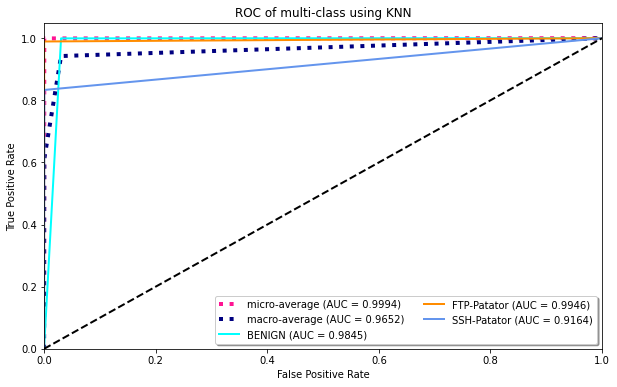

Train AUC: 1.0000 vs Test AUC: 0.9998


In [38]:
from sklearn.neighbors import KNeighborsClassifier

# Creat and Train KNN model
KNN = KNeighborsClassifier(n_neighbors=3, weights='uniform')
KNN.fit(x_train, encoded_y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = KNN.predict(x_train)
KNN_train = record_measures(encoded_y_train, y_pred)

# Predict testing data
y_predicted = KNN.predict(x_test)

# Print performance measures
print_performance('KNN', encoded_y_test, y_predicted, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
KNN_test = record_measures( encoded_y_test, y_predicted)

# Print ROC Curve
plot_ROC(KNN_test, labels_dict, 'KNN')
if n_classes > 2:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(DT_train['auc']['micro'], DT_test['auc']['micro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(DT_train['auc'], DT_test['auc']))

<Figure size 720x720 with 0 Axes>

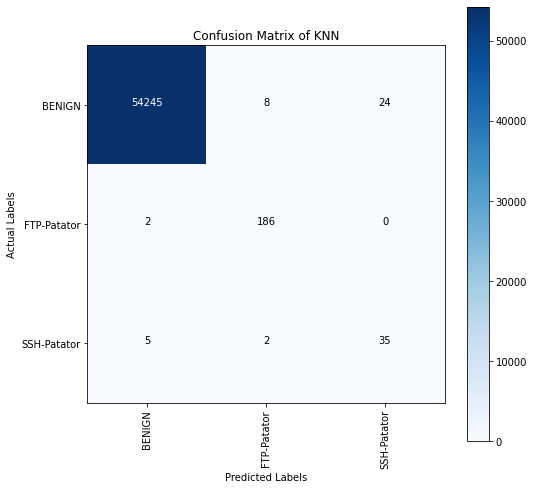

In [39]:
# Color Confusion Matrix
color_confusion_matrix('KNN', encoded_y_test, y_predicted, OG_labels)

# **LightGBM**

Note: LightGBM can only be trained with labels 0,1,2,3,4,5, etc. not binarized labels

ROC AUC Class  0 : 0.9999842078250227
ROC AUC Class  1 : 0.9999940779343834
ROC AUC Class  2 : 0.9999980259781278
Confusion Matrix: 
 [[54270     7     0]
 [    0   188     0]
 [    1     0    41]]

Classification report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     54277
 FTP-Patator       0.96      1.00      0.98       188
 SSH-Patator       1.00      0.98      0.99        42

   micro avg       1.00      1.00      1.00     54507
   macro avg       0.99      0.99      0.99     54507
weighted avg       1.00      1.00      1.00     54507
 samples avg       1.00      1.00      1.00     54507


Testing Accuracy: 1.00
Micro AUC: 0.9999
Macro AUC: 0.9953
ROC AUC Class  0 : 0.9977616029209265
ROC AUC Class  1 : 0.9999355658241131
ROC AUC Class  2 : 0.9880952380952381


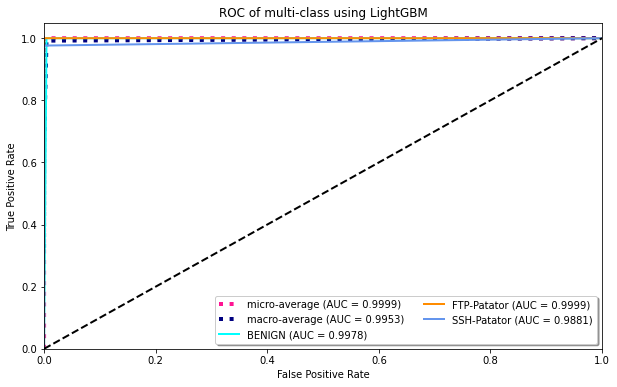

Train AUC: 1.0000 vs Test AUC: 0.9998


In [40]:
from lightgbm import LGBMClassifier

# Train LightGBM Classifier
if n_classes > 2:
  lgbmc = LGBMClassifier(objective= 'multiclass')
 
  #y_pred = label_binarize(y_pred, classes= label_range)
else:
  lgbmc = LGBMClassifier(objective= 'binary')
  
lgbmc.fit(x_train, y_train)
y_pred = lgbmc.predict(x_train)
y_pred = label_binarize(y_pred, classes= label_range)

# Recording TPR and FPR for TRAINING-ROC curves
LGBM_train = record_measures(encoded_y_train, y_pred)

# Predict test data
y_predicted = lgbmc.predict(x_test)

# Encode y_predicted:
y_pred_encoded = label_binarize(y_predicted, classes= label_range)

# Print performance measures
print_performance('LightGBM', encoded_y_test, y_pred_encoded, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
LGBM_test = record_measures(encoded_y_test, y_pred_encoded)

# Print ROC Curve
plot_ROC(LGBM_test, labels_dict, 'LightGBM')
if n_classes > 2:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(DT_train['auc']['micro'], DT_test['auc']['micro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(DT_train['auc'], DT_test['auc']))

<Figure size 720x720 with 0 Axes>

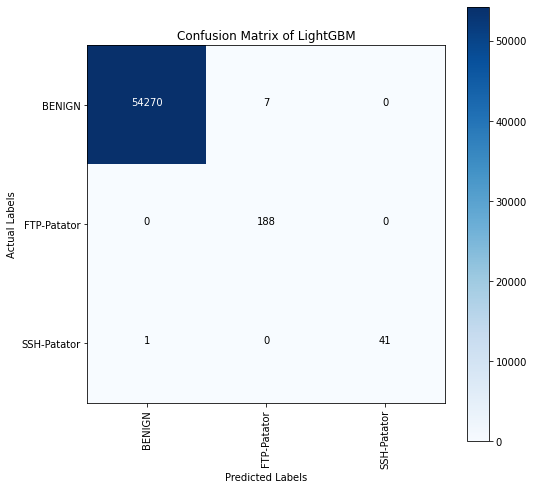

In [41]:
# Color Confusion Matrix
color_confusion_matrix('LightGBM', encoded_y_test, y_pred_encoded, OG_labels)

# **XGBoost**

ROC AUC Class  0 : 0.9999368313000908
ROC AUC Class  1 : 0.9999921039125114
ROC AUC Class  2 : 0.999976311737534


Testing Result of XGBoost:
Confusion Matrix: 
 [[54267     5     5]
 [    0   188     0]
 [    0     0    42]]

Classification report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     54277
 FTP-Patator       0.97      1.00      0.99       188
 SSH-Patator       0.89      1.00      0.94        42

   micro avg       1.00      1.00      1.00     54507
   macro avg       0.96      1.00      0.98     54507
weighted avg       1.00      1.00      1.00     54507
 samples avg       1.00      1.00      1.00     54507


Testing Accuracy: 1.00
Micro AUC: 0.9999
Macro AUC: 0.9999
ROC AUC Class  0 : 0.9999078799491498
ROC AUC Class  1 : 0.9999539755886523
ROC AUC Class  2 : 0.9999540989626365


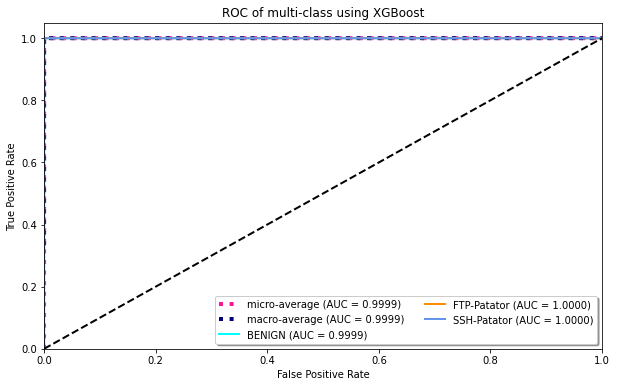

Train AUC: 1.0000 vs Test AUC: 0.9999


In [42]:
from xgboost import XGBClassifier

# Train XGBoost Classifier
xgb = XGBClassifier(eval_metric="logloss")

xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_train)
y_pred = label_binarize(y_pred, classes= label_range)


# Recording TPR and FPR for TRAINING-ROC curves
XGB_train = record_measures(encoded_y_train, y_pred)

# Predict test data
y_predicted = xgb.predict(x_test)

# Encode y_predicted:
y_pred_encoded = label_binarize(y_predicted, classes= label_range)

# Print performance measures
print('\n\nTesting Result of XGBoost:')
print_performance('LightGBM', encoded_y_test, y_pred_encoded, OG_labels)

# Recording TPR and FPR for TESTING-ROC curves
XGB_test = record_measures(encoded_y_test, y_pred_encoded)

# Print ROC Curve
plot_ROC(XGB_test, labels_dict, 'XGBoost')
if n_classes > 2:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(XGB_train['auc']['micro'], XGB_test['auc']['micro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(XGB_train['auc'],XGB_test['auc']))


<Figure size 720x720 with 0 Axes>

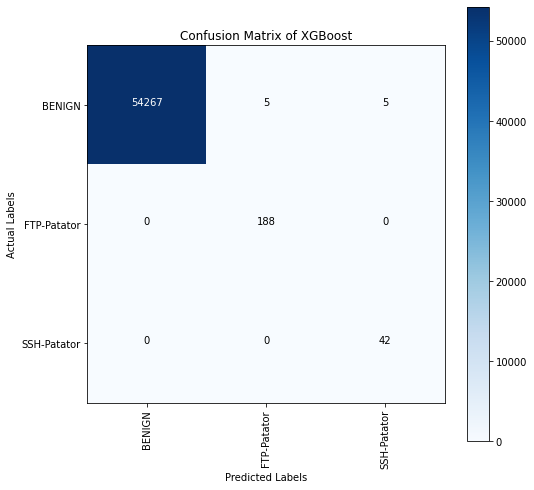

In [43]:
# Color Confusion Matrix
color_confusion_matrix('XGBoost', encoded_y_test, y_pred_encoded, OG_labels)

 Ploting the overlaid ROC curves on testing results:
graph_multi_ROC()

In [44]:
#graph_multi_ROC()

# **BERT**


# **Multi-class BERT**

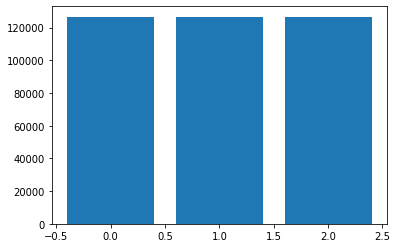

In [45]:
# plot the distribution
counter = Counter(y_train)

plt.bar(counter.keys(), counter.values())
plt.show()

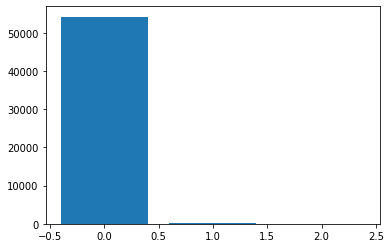

In [46]:
# plot the distribution
counter = Counter(y_test)

plt.bar(counter.keys(), counter.values())
plt.show()

## **Combining all features into a sentence**

In [47]:
train_texts = []
for i in range(x_train.shape[0]):
     train_texts.append(" ".join(np.array(x_train.iloc[i,:]).astype(str)))
train_texts = tuple(train_texts) 


In [48]:
train_texts

('0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 4388.0 60236.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -1.0',
 '0.0 0.0 0.0 0.0 0.0 16.0 1.0 0.0 100.4761905 74.77272727 74.77272727 8192.0 80.0 0.0 98.13953488 1.0 185.7941233 329.0 580.0 141.118637 580.0 34519.45626 6944.0',
 '0.0 0.0 0.0 0.0 0.0 6.0 1.0 0.0 482.66666669999995 1109.181818 1109.181818 65535.0 443.0 0.0 465.42857139999995 0.0 819.7633547 2789.0 2789.0 1022.809251 357.0 672011.9577 61.0',
 '0.0 0.0 0.0 52.0 107.0 1.0 0.0 52.0 99.5 117.0 117.0 -1.0 53.0 0.0 79.6 1.0 34.90415448 127.0 127.0 14.14213562 56.0 1218.3 -1.0',
 '0.0 0.0 0.0 0.0 0.0 3.0 1.0 0.0 398.2 645.875 645.875 8192.0 443.0 0.0 373.3125 1.0 561.0527864000001 1460.0 1460.0 689.1563035 486.0 314780.2292 40.0',
 '0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 385.0 58449.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 258.0',
 '0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 122.0 53800.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 33304.0',
 '0.0 0.0 0.0 0.0 0.0 11.0 0.0 0.0 1668.571428999999

In [49]:
test_texts = []
for i in range(x_test.shape[0]):
     test_texts.append(" ".join(np.array(x_test.iloc[i,:]).astype(str)))
test_texts = tuple(test_texts)

In [50]:
encoded_y_train.head()

,0,1,2
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [51]:
!pip install transformers

# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [52]:
### --------- Setup BERT ---------- ###
# Name of the BERT model to use
model_name = 'bert-base-uncased'
# Max length of tokens
if len(X.columns) > 30:
  max_length = 50
elif 20<= len(X.columns) <= 30:
  max_length =  40
elif 10 < len(X.columns) < 20:
  max_length = 30
else:
  max_length = 9 # for the rest of the datasets

if INDEX == 2:
  max_length = 6 # for dataset index 2

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [53]:
### ------- Build the model ------- ###

# TF Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model

# Load the MainLayer
bert = transformer_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
label = Dense(units=len(label_range), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='label')(pooled_output)
#product = Dense(units=len(data.Product_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='product')(pooled_output)
outputs = {'label': label}

# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')

# Take a look at the model
model.summary()

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Model: "BERT_MultiLabel_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 40)]              0         
_________________________________________________________________
bert (TFBertMainLayer)       TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
label (Dense)                (None, 3)                 2307      
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________


In [ ]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = {'label': CategoricalCrossentropy(from_logits = True)}
metric = {'label': CategoricalAccuracy('accuracy')}

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

# Ready output data for the model
if n_classes == 2:
  encoded_labels = to_categorical(encoded_y_train)
else:
  encoded_labels = encoded_y_train

# Tokenize the input (takes some time)
x = tokenizer(
    text= list(train_texts),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids']},
    y={'label': encoded_labels},
    validation_split=0.2,
    batch_size=256,
    epochs = 2)

Epoch 1/2
 376/1188 [========>.....................] - ETA: 27:19 - loss: 0.0524 - accuracy: 0.9856

In [ ]:
y_train_pred = model.predict(x={'input_ids': x['input_ids']}, verbose = 1)

y_train_pred_encoded = label_binarize(y_train_pred['label'].argmax(axis=1), classes= label_range)

# Recording TPR and FPR for TRAINING-ROC curves
if n_classes > 2:
  BERT_train = record_measures( encoded_y_train, y_train_pred_encoded) 
else:
  BERT_train = record_measures( y_train, y_train_pred_encoded) 

In [ ]:
### ----- Evaluate the model ------ ###

# Ready test data
if n_classes == 2:
  encoded_test_labels = to_categorical(encoded_y_test)
else:
  encoded_test_labels = encoded_y_test

test_x = tokenizer(
    text= list(test_texts),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

# Run evaluation
model_eval = model.evaluate(
    x={'input_ids': test_x['input_ids']},
    y={'label': encoded_test_labels}
)

In [ ]:
y_predicted = model.predict( x={'input_ids': test_x['input_ids']}, verbose=1 )

# Encode y_predicted: ***************************
y_pred_encoded = label_binarize(y_predicted['label'].argmax(axis=1), classes= label_range)
#y_pred_encoded, encoded_y_test

In [ ]:
# Print performance measures
if n_classes > 2:
  print_performance('BERT', encoded_y_test, y_pred_encoded, OG_labels)
  BERT_test = record_measures( encoded_y_test, y_pred_encoded)    # Recording TPR and FPR for TESTING-ROC curves
else:
  print_performance('BERT', y_test, y_pred_encoded, OG_labels)
  BERT_test = record_measures( y_test, y_pred_encoded)            # Recording TPR and FPR for TESTING-ROC curves

# Print ROC Curve
plot_ROC(BERT_test, labels_dict, 'BERT')


if n_classes > 2:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(BERT_train['auc']['micro'], BERT_test['auc']['micro']))
else:
  print('Train AUC: %.4f vs Test AUC: %.4f' %(BERT_train['auc'],BERT_test['auc']))

In [ ]:
# Color Confusion Matrix
if n_classes > 2:
  color_confusion_matrix('BERT', encoded_y_test, y_pred_encoded, OG_labels)
else:
  color_confusion_matrix('BERT', y_test, y_pred_encoded, OG_labels)


# **GPT-2**

# **Graphing multi-ROC Curves**

In [ ]:
# Ploting the overlaid ROC curves on testing results:
# Graph micro AUC
graph_multi_ROC()

# Graph macro AUC
graph_multi_ROC('macro')

# **NOTE**
**No need to scale data because BERT doesn't work well with that**

0 - Friday-WorkingHours-Afternoon-DDos: has 30 col features and 2 classes. This dataset only has 3 overlapped records between the two classes. Therefore, cleaning data only helped a little bit in this case. Their AUCs are above 0.99.

1 - Friday-WorkingHours-Afternoon-PortScan: has 30 col features and 2 classes. This dataset has no overlap records between 2 classes. Therefore, cleaning data did not affect the algorithms' performances. Their AUCs are above 0.99.

2 - Friday-WorkingHours-Morning: has 3 col features and 2 classes. This dataset is extremely unbalanced. Intrusion class only has 4 unique records and 1 of them is overlapped with a normal unique record. Before cleaning, all algorithms achieve AUC around 0.83, and after cleaning, their AUC are 1.0.

3 - Monday: Only contains normal class, so we did not analyze it.

4 - Thursday-WorkingHours-Afternoon-Infilteration: has 13 col features and 2 classes. All multiclass classifiers perform very well (AUC above 0.98). Result after cleaning is similar to before cleaning since this dataset contains distinctive records from each class.

5 - Thursday-WorkingHours-Morning-WebAttacks: has 3 col features and 4 classes and all multiclass classifiers perform adequately (AUC around 0.85). All algs misclassified Brute Force for XSS because they have very similar values in the best features. This is also because this dataset is extremely imbalance, so I have to oversample (bootstrap) most intrusion classes (1-3), hence the similar feature values.
  >--> Solution Proposal: Add another feature column. Result: not working. Class 1 and 3 has more intersects if added another feature. All algs still misclassifies class 1 and 3.
  
  >--> Solution Proposal: Clean data thoroughly by removing any cases that exist in more than one classes. Result all algorithms work extremely well with AUC above 0.99.

6 - Tuesday Working Hour: has 3 classes and all multiclass classifiers (including BERT) perform very well (AUC above 0.99). Result after cleaning is similar to before cleaning since this dataset contains distinctive records from each class.

7 - Wednesday Working Hour: has 5 classes and all multiclass classifiers (including BERT) perform very well (AUC above 0.98).  Result after cleaning doesn't change that much since the data does not overlap as much in this dataset

